In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
!ls gdrive/MyDrive/datasets/ham10000

HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata.csv


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(0)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
base_skin_dir = os.path.join('', 'gdrive/MyDrive/datasets/ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head(20)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2


In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [9]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [10]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


<Axes: >

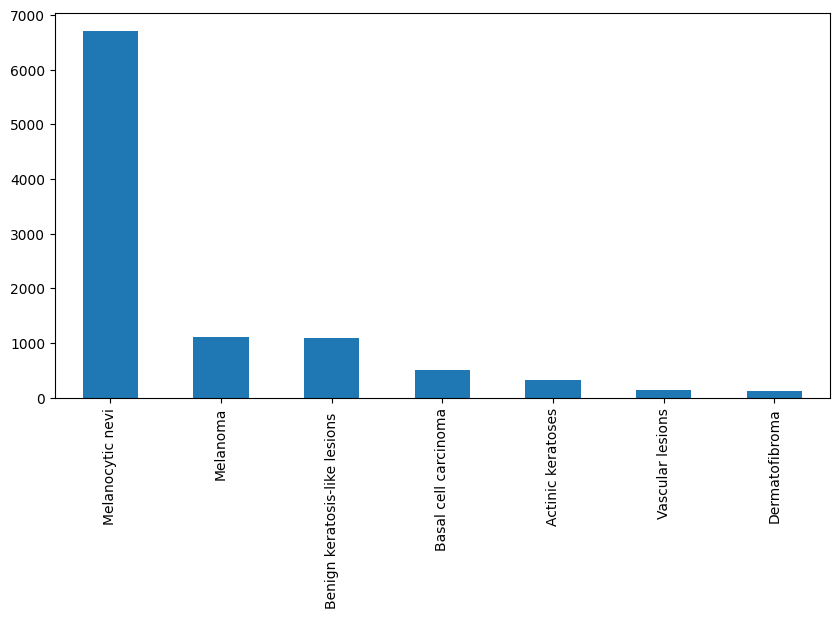

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

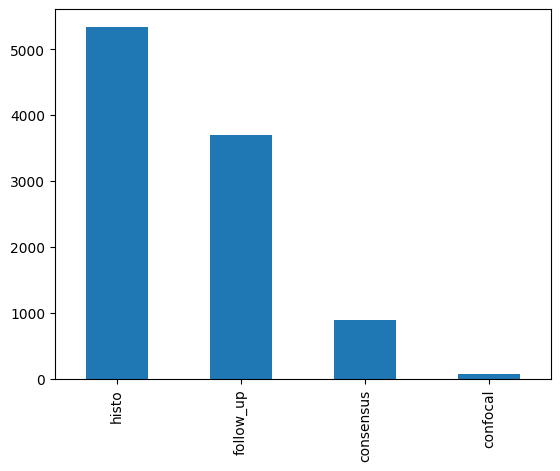

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: >

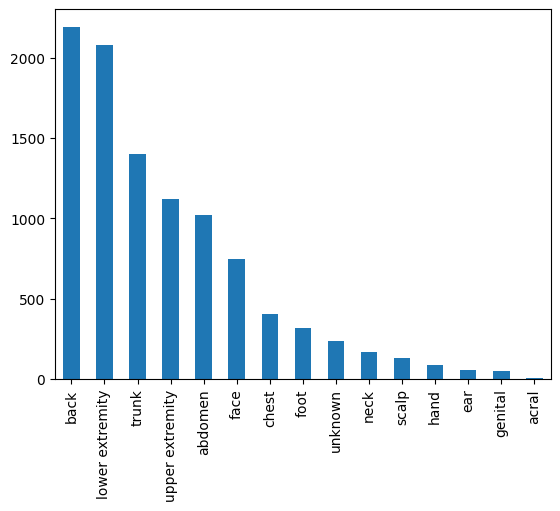

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

<Axes: >

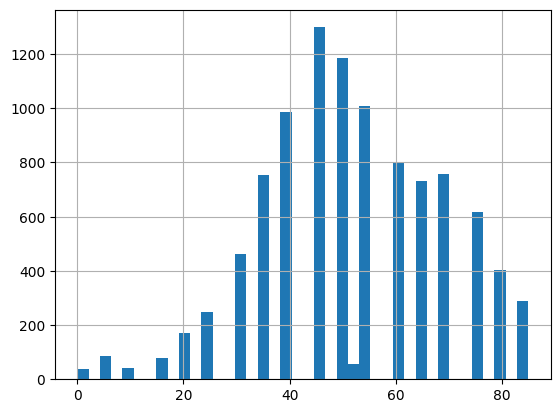

In [ ]:
skin_df['age'].hist(bins=40)

<Axes: >

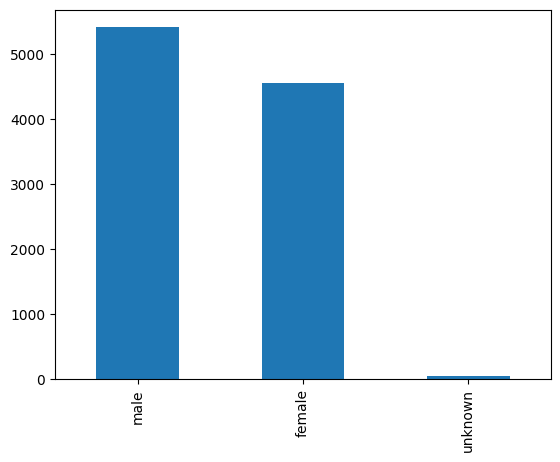

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [12]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
image             object
dtype: object


In [ ]:
skin_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/ham10000_224_224.csv')

In [15]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ham10000_224_224.csv')
test = test.drop(['Unnamed: 0'], axis=1)

In [13]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [14]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=0).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 100, 3)    10015
Name: image, dtype: int64

In [12]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [13]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=0)

In [14]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [15]:
import torch
import torchvision.datasets

In [16]:
X_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train_o.to_numpy())
X_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test_o.to_numpy())

In [14]:
X_train.shape, y_train.shape

(torch.Size([8012, 224, 224, 3]), torch.Size([8012]))

In [17]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [18]:
X_train /= 255.
X_test /= 255.

In [19]:
import torch
import random
import numpy as np
import pandas as pd

import torchvision.datasets
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [24]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [25]:
import pytorch_optimizer as optim

In [46]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=5.0e-2)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters())
    #optimizer = optim.AdaBelief(net.parameters())
    optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 9

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        if epoch == 12:
            #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-5)
            #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-4)
            #optimizer = optim.AdaBelief(net.parameters(), lr=1.0e-4)
            optimizer = optim.DiffGrad(net.parameters(), lr=1.0e-4)
            #optimizer = optim.Yogi(net.parameters(), lr=1.0e-4)
    

        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    return test_accuracy_history, test_loss_history

In [21]:
accuracies = {}
losses = {}

In [22]:
from torchvision.models import resnet50, ResNet50_Weights

In [23]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Adam'], losses['resnet50+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch  0


100%|██████████| 401/401 [00:40<00:00,  9.91it/s]


accuracy =  0.7568647265434265



epoch  1


100%|██████████| 401/401 [00:33<00:00, 12.13it/s]


accuracy =  0.778332531452179



epoch  2


100%|██████████| 401/401 [00:33<00:00, 11.89it/s]


accuracy =  0.7603594660758972



epoch  3


100%|██████████| 401/401 [00:34<00:00, 11.59it/s]


accuracy =  0.7713429927825928



epoch  4


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.7708437442779541



epoch  5


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.7768347263336182



epoch  6


100%|██████████| 401/401 [00:34<00:00, 11.57it/s]


accuracy =  0.7618572115898132



epoch  7


100%|██████████| 401/401 [00:34<00:00, 11.63it/s]


accuracy =  0.7883175015449524



epoch  8


100%|██████████| 401/401 [00:34<00:00, 11.58it/s]


accuracy =  0.7059410810470581



epoch  9


100%|██████████| 401/401 [00:34<00:00, 11.49it/s]


accuracy =  0.7538691759109497



epoch  10


100%|██████████| 401/401 [00:34<00:00, 11.64it/s]


accuracy =  0.778332531452179



epoch  11


100%|██████████| 401/401 [00:34<00:00, 11.62it/s]


accuracy =  0.7448827028274536



epoch  12


100%|██████████| 401/401 [00:34<00:00, 11.59it/s]


accuracy =  0.7903145551681519



epoch  13


100%|██████████| 401/401 [00:38<00:00, 10.32it/s]


accuracy =  0.7918123006820679



epoch  14


100%|██████████| 401/401 [00:40<00:00,  9.99it/s]


accuracy =  0.7958062887191772



epoch  15


100%|██████████| 401/401 [00:40<00:00,  9.99it/s]


accuracy =  0.800798773765564



epoch  16


100%|██████████| 401/401 [00:39<00:00, 10.16it/s]


accuracy =  0.8067898154258728



epoch  17


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.8077883124351501



epoch  18


100%|██████████| 401/401 [00:38<00:00, 10.47it/s]


accuracy =  0.8062905669212341



epoch  19


100%|██████████| 401/401 [00:34<00:00, 11.50it/s]


accuracy =  0.8072890639305115





In [31]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+PNMBelief'], losses['resnet50+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [01:09<00:00, 12.81it/s]


accuracy =  0.7403894066810608



epoch  1


100%|██████████| 891/891 [01:05<00:00, 13.61it/s]


accuracy =  0.7883175015449524



epoch  2


100%|██████████| 891/891 [01:04<00:00, 13.73it/s]


accuracy =  0.750374436378479



epoch  3


100%|██████████| 891/891 [01:04<00:00, 13.79it/s]


accuracy =  0.7738392353057861



epoch  4


100%|██████████| 891/891 [01:05<00:00, 13.54it/s]


accuracy =  0.7803295254707336



epoch  5


100%|██████████| 891/891 [01:04<00:00, 13.74it/s]


accuracy =  0.7758362293243408



epoch  6


100%|██████████| 891/891 [01:05<00:00, 13.68it/s]


accuracy =  0.785821259021759



epoch  7


100%|██████████| 891/891 [01:04<00:00, 13.80it/s]


accuracy =  0.7338991761207581



epoch  8


100%|██████████| 891/891 [01:05<00:00, 13.59it/s]


accuracy =  0.779830276966095



epoch  9


100%|██████████| 891/891 [01:04<00:00, 13.74it/s]


accuracy =  0.7363954186439514



epoch  10


100%|██████████| 891/891 [01:05<00:00, 13.56it/s]


accuracy =  0.7943085432052612



epoch  11


100%|██████████| 891/891 [01:11<00:00, 12.55it/s]


accuracy =  0.7928107976913452



epoch  12


100%|██████████| 891/891 [01:14<00:00, 11.94it/s]


accuracy =  0.7983025312423706



epoch  13


100%|██████████| 891/891 [01:07<00:00, 13.15it/s]


accuracy =  0.7968047857284546



epoch  14


100%|██████████| 891/891 [01:08<00:00, 13.08it/s]


accuracy =  0.8027958273887634



epoch  15


100%|██████████| 891/891 [01:19<00:00, 11.26it/s]


accuracy =  0.8112830519676208



epoch  16


100%|██████████| 891/891 [01:06<00:00, 13.48it/s]


accuracy =  0.8217673301696777



epoch  17


100%|██████████| 891/891 [01:05<00:00, 13.59it/s]


accuracy =  0.8107838034629822



epoch  18


100%|██████████| 891/891 [01:06<00:00, 13.41it/s]


accuracy =  0.8132801055908203



epoch  19


100%|██████████| 891/891 [01:06<00:00, 13.36it/s]


accuracy =  0.8212680816650391





In [40]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Yogi'], losses['resnet50+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [00:56<00:00, 15.78it/s]


accuracy =  0.7648527026176453



epoch  1


100%|██████████| 891/891 [00:59<00:00, 15.04it/s]


accuracy =  0.7748377323150635



epoch  2


100%|██████████| 891/891 [00:56<00:00, 15.76it/s]


accuracy =  0.7678482532501221



epoch  3


100%|██████████| 891/891 [00:57<00:00, 15.52it/s]


accuracy =  0.7918123006820679



epoch  4


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.7878182530403137



epoch  5


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.7753369808197021



epoch  6


100%|██████████| 891/891 [00:57<00:00, 15.62it/s]


accuracy =  0.7978032827377319



epoch  7


100%|██████████| 891/891 [00:56<00:00, 15.75it/s]


accuracy =  0.7523714303970337



epoch  8


100%|██████████| 891/891 [00:56<00:00, 15.73it/s]


accuracy =  0.7748377323150635



epoch  9


100%|██████████| 891/891 [00:57<00:00, 15.61it/s]


accuracy =  0.7888167500495911



epoch  10


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.8077883124351501



epoch  11


100%|██████████| 891/891 [00:56<00:00, 15.70it/s]


accuracy =  0.8062905669212341



epoch  12


100%|██████████| 891/891 [00:56<00:00, 15.87it/s]


accuracy =  0.8242636322975159



epoch  13


100%|██████████| 891/891 [00:57<00:00, 15.56it/s]


accuracy =  0.8247628808021545



epoch  14


100%|██████████| 891/891 [00:56<00:00, 15.73it/s]


accuracy =  0.8222665786743164



epoch  15


100%|██████████| 891/891 [00:56<00:00, 15.72it/s]


accuracy =  0.8232650756835938



epoch  16


100%|██████████| 891/891 [00:57<00:00, 15.46it/s]


accuracy =  0.8267598748207092



epoch  17


100%|██████████| 891/891 [00:57<00:00, 15.57it/s]


accuracy =  0.8177733421325684



epoch  18


100%|██████████| 891/891 [00:56<00:00, 15.72it/s]


accuracy =  0.8237643837928772



epoch  19


100%|██████████| 891/891 [00:57<00:00, 15.61it/s]


accuracy =  0.8172740936279297





In [47]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+DiffGrad'], losses['resnet50+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [01:13<00:00, 12.20it/s]


accuracy =  0.7673490047454834



epoch  1


100%|██████████| 891/891 [01:13<00:00, 12.13it/s]


accuracy =  0.7598602175712585



epoch  2


100%|██████████| 891/891 [01:08<00:00, 12.96it/s]


accuracy =  0.7788317799568176



epoch  3


100%|██████████| 891/891 [01:10<00:00, 12.66it/s]


accuracy =  0.7888167500495911



epoch  4


100%|██████████| 891/891 [01:09<00:00, 12.88it/s]


accuracy =  0.7868197560310364



epoch  5


100%|██████████| 891/891 [01:08<00:00, 13.03it/s]


accuracy =  0.7838242650032043



epoch  6


100%|██████████| 891/891 [01:09<00:00, 12.80it/s]


accuracy =  0.7898153066635132



epoch  7


100%|██████████| 891/891 [01:08<00:00, 12.95it/s]


accuracy =  0.7683475017547607



epoch  8


100%|██████████| 891/891 [01:10<00:00, 12.67it/s]


accuracy =  0.7763354778289795



epoch  9


100%|██████████| 891/891 [01:08<00:00, 12.99it/s]


accuracy =  0.7793310284614563



epoch  10


100%|██████████| 891/891 [01:08<00:00, 12.97it/s]


accuracy =  0.7738392353057861



epoch  11


100%|██████████| 891/891 [01:09<00:00, 12.80it/s]


accuracy =  0.7693459987640381



epoch  12


100%|██████████| 891/891 [01:09<00:00, 12.90it/s]


accuracy =  0.8072890639305115



epoch  13


100%|██████████| 891/891 [01:08<00:00, 13.07it/s]


accuracy =  0.8037943243980408



epoch  14


100%|██████████| 891/891 [01:09<00:00, 12.77it/s]


accuracy =  0.8097853064537048



epoch  15


100%|██████████| 891/891 [01:09<00:00, 12.91it/s]


accuracy =  0.8057913184165955



epoch  16


100%|██████████| 891/891 [01:09<00:00, 12.78it/s]


accuracy =  0.8082875609397888



epoch  17


100%|██████████| 891/891 [01:08<00:00, 12.95it/s]


accuracy =  0.8147778511047363



epoch  18


100%|██████████| 891/891 [01:08<00:00, 13.00it/s]


accuracy =  0.8097853064537048



epoch  19


100%|██████████| 891/891 [01:10<00:00, 12.62it/s]


accuracy =  0.8107838034629822





In [26]:
APreds = pd.DataFrame()

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = []
model.eval()
with torch.no_grad():
            test_preds = model.forward(X_test)

In [28]:
APreds['Adam'] = test_preds.argmax(dim=1).tolist()

In [35]:
APreds['PNMBelief'] = test_preds.argmax(dim=1).tolist()

In [42]:
APreds['Yogi'] = test_preds.argmax(dim=1).tolist()

In [49]:
APreds['DiffGrad'] = test_preds.argmax(dim=1).tolist()

In [50]:
APreds

,Adam,PNMBelief,Yogi,DiffGrad
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,0,4,4,2
4,4,4,4,2
...,...,...,...,...
1998,4,4,4,4
1999,4,5,4,4
2000,4,4,4,4
2001,4,4,4,4


In [ ]:
APreds = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_ham10000_v1.csv')
APreds = APreds.drop(['Unnamed: 0'], axis=1)

In [51]:
APreds.to_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_ham10000_v1.csv')

In [ ]:
APreds

In [57]:
data = np.zeros((2003,7), dtype=int)
ARes = pd.DataFrame(data)

In [58]:
for i in range(2003):
    for j in range(4):
        if j == 0:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.807289
        if j == 1:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.821268
        if j == 2:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.817274
        if j == 3:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.8107838

In [59]:
anslist = ARes.idxmax(axis=1)

In [60]:
accuracy = (torch.tensor(anslist).to(device) == y_test).float().mean().item()

In [61]:
accuracy

0.8362456560134888

In [63]:
type(anslist.to_list())

list

In [52]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1


In [33]:
D #Adam

,0,1,2,3,4,5,6,7,8,9
0,22,8,5,4,3,7,0,0,0,0
1,13,74,3,2,6,8,2,0,0,0
2,16,5,112,3,36,22,1,0,0,0
3,0,1,1,13,1,1,0,0,0,0
4,4,13,51,4,1262,75,3,0,0,0
5,6,8,26,2,43,110,0,0,0,0
6,0,2,0,1,0,0,24,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [38]:
D #PNMBelief

,0,1,2,3,4,5,6,7,8,9
0,32,14,5,0,1,6,0,0,0,0
1,5,64,4,0,12,4,2,0,0,0
2,10,2,108,2,30,16,1,0,0,0
3,0,4,0,22,0,0,0,0,0,0
4,5,20,53,3,1272,72,3,0,0,0
5,9,6,28,2,34,123,0,0,0,0
6,0,1,0,0,2,2,24,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [44]:
D #Yogi

,0,1,2,3,4,5,6,7,8,9
0,34,6,11,3,4,10,0,0,0,0
1,8,74,4,1,12,5,2,0,0,0
2,9,9,105,2,25,16,0,0,0,0
3,0,2,0,16,1,0,0,0,0,0
4,3,14,54,4,1281,90,1,0,0,0
5,7,5,24,2,28,101,1,0,0,0
6,0,1,0,1,0,1,26,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [53]:
D #DiffGrad

,0,1,2,3,4,5,6,7,8,9
0,26,9,11,2,3,10,0,0,0,0
1,9,72,2,3,9,8,1,0,0,0
2,10,7,104,1,19,15,0,0,0,0
3,3,6,2,19,4,2,1,0,0,0
4,5,14,53,3,1273,81,3,0,0,0
5,8,1,26,0,39,105,0,0,0,0
6,0,2,0,1,4,2,25,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [64]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

for x, y in zip(anslist.to_list(), y_test.tolist()):
    D[y][x] += 1

In [65]:
D #ansamble

,0,1,2,3,4,5,6,7,8,9
0,32,6,6,1,1,7,0,0,0,0
1,8,76,2,1,8,5,2,0,0,0
2,10,2,114,2,25,13,1,0,0,0
3,0,3,0,20,0,0,0,0,0,0
4,2,17,51,3,1291,80,2,0,0,0
5,9,6,25,1,24,117,0,0,0,0
6,0,1,0,1,2,1,25,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


# 1

In [ ]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

In [ ]:
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

In [ ]:
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


<ipython-input-36-b36dfc5ecc8e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


720/721 [============================>.] - ETA: 0s - loss: 1.0185 - accuracy: 0.6642

721/721 [==============================] - 31s 29ms/step - loss: 1.0185 - accuracy: 0.6639 - val_loss: 0.8939 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.6712

721/721 [==============================] - 18s 25ms/step - loss: 0.9184 - accuracy: 0.6712 - val_loss: 0.8456 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 3/50
721/721 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6774

721/721 [==============================] - 20s 28ms/step - loss: 0.8866 - accuracy: 0.6774 - val_loss: 0.8274 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 4/50
719/721 [============================>.] - ETA: 0s - loss: 0.8556 - accuracy: 0.6898

721/721 [==============================] - 19s 26ms/step - loss: 0.8559 - accuracy: 0.6899 - val_loss: 0.7960 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - ETA: 0s - loss: 0.8356 - accuracy: 0.6975

721/721 [==============================] - 18s 26ms/step - loss: 0.8356 - accuracy: 0.6975 - val_loss: 0.8157 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 6/50
721/721 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.7010

721/721 [==============================] - 20s 27ms/step - loss: 0.8180 - accuracy: 0.7010 - val_loss: 0.7331 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 7/50
719/721 [============================>.] - ETA: 0s - loss: 0.8005 - accuracy: 0.7072

721/721 [==============================] - 19s 26ms/step - loss: 0.7997 - accuracy: 0.7075 - val_loss: 0.7355 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 8/50
720/721 [============================>.] - ETA: 0s - loss: 0.7817 - accuracy: 0.7121

721/721 [==============================] - 22s 31ms/step - loss: 0.7815 - accuracy: 0.7121 - val_loss: 0.7818 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 9/50
721/721 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.7160

721/721 [==============================] - 20s 27ms/step - loss: 0.7747 - accuracy: 0.7160 - val_loss: 0.7139 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 10/50
721/721 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.7264

721/721 [==============================] - 19s 26ms/step - loss: 0.7626 - accuracy: 0.7264 - val_loss: 0.6744 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 11/50
719/721 [============================>.] - ETA: 0s - loss: 0.7536 - accuracy: 0.7245

721/721 [==============================] - 18s 26ms/step - loss: 0.7532 - accuracy: 0.7247 - val_loss: 0.7195 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 12/50
720/721 [============================>.] - ETA: 0s - loss: 0.7603 - accuracy: 0.7237

721/721 [==============================] - 20s 28ms/step - loss: 0.7606 - accuracy: 0.7237 - val_loss: 0.6950 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 13/50
720/721 [============================>.] - ETA: 0s - loss: 0.7483 - accuracy: 0.7282

721/721 [==============================] - 19s 26ms/step - loss: 0.7485 - accuracy: 0.7280 - val_loss: 0.7271 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 14/50
719/721 [============================>.] - ETA: 0s - loss: 0.7397 - accuracy: 0.7309

721/721 [==============================] - 20s 28ms/step - loss: 0.7403 - accuracy: 0.7309 - val_loss: 0.7022 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 15/50
719/721 [============================>.] - ETA: 0s - loss: 0.7412 - accuracy: 0.7298

721/721 [==============================] - 18s 25ms/step - loss: 0.7421 - accuracy: 0.7293 - val_loss: 0.7156 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 16/50
720/721 [============================>.] - ETA: 0s - loss: 0.7135 - accuracy: 0.7362

721/721 [==============================] - 21s 29ms/step - loss: 0.7129 - accuracy: 0.7365 - val_loss: 0.6577 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 17/50
720/721 [============================>.] - ETA: 0s - loss: 0.7193 - accuracy: 0.7351

721/721 [==============================] - 19s 26ms/step - loss: 0.7187 - accuracy: 0.7354 - val_loss: 0.6906 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 18/50
720/721 [============================>.] - ETA: 0s - loss: 0.7177 - accuracy: 0.7360

721/721 [==============================] - 19s 26ms/step - loss: 0.7178 - accuracy: 0.7361 - val_loss: 0.7011 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 19/50
719/721 [============================>.] - ETA: 0s - loss: 0.7057 - accuracy: 0.7394

721/721 [==============================] - 19s 26ms/step - loss: 0.7050 - accuracy: 0.7395 - val_loss: 0.6701 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 20/50
721/721 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.7451

721/721 [==============================] - 19s 26ms/step - loss: 0.7016 - accuracy: 0.7451 - val_loss: 0.6944 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 21/50
720/721 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.7443

721/721 [==============================] - 18s 26ms/step - loss: 0.6938 - accuracy: 0.7442 - val_loss: 0.6818 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 22/50
721/721 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.7422

721/721 [==============================] - 18s 26ms/step - loss: 0.6994 - accuracy: 0.7422 - val_loss: 0.6853 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 23/50
720/721 [============================>.] - ETA: 0s - loss: 0.7403 - accuracy: 0.7426

721/721 [==============================] - 19s 27ms/step - loss: 0.7400 - accuracy: 0.7427 - val_loss: 0.6668 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 24/50
721/721 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7476

721/721 [==============================] - 18s 26ms/step - loss: 0.6962 - accuracy: 0.7476 - val_loss: 0.6932 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 25/50
721/721 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.7452

721/721 [==============================] - 21s 30ms/step - loss: 0.7018 - accuracy: 0.7452 - val_loss: 0.6950 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 26/50
719/721 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.7462

721/721 [==============================] - 19s 27ms/step - loss: 0.6847 - accuracy: 0.7466 - val_loss: 0.6567 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 27/50
721/721 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7426

721/721 [==============================] - 18s 25ms/step - loss: 0.7096 - accuracy: 0.7426 - val_loss: 0.6960 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 28/50
720/721 [============================>.] - ETA: 0s - loss: 0.7026 - accuracy: 0.7428

721/721 [==============================] - 20s 28ms/step - loss: 0.7032 - accuracy: 0.7426 - val_loss: 0.6551 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 29/50
720/721 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.7465

721/721 [==============================] - 19s 26ms/step - loss: 0.6847 - accuracy: 0.7463 - val_loss: 0.6645 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 30/50
721/721 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.7510

721/721 [==============================] - 19s 27ms/step - loss: 0.6730 - accuracy: 0.7510 - val_loss: 0.6568 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 31/50
721/721 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.7474

721/721 [==============================] - 19s 26ms/step - loss: 0.6829 - accuracy: 0.7474 - val_loss: 0.6618 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 32/50
721/721 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7512

721/721 [==============================] - 20s 27ms/step - loss: 0.6755 - accuracy: 0.7512 - val_loss: 0.6325 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 33/50
721/721 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7535

721/721 [==============================] - 21s 29ms/step - loss: 0.6745 - accuracy: 0.7535 - val_loss: 0.6616 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 34/50
720/721 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.7569

721/721 [==============================] - 19s 26ms/step - loss: 0.6680 - accuracy: 0.7570 - val_loss: 0.6617 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 35/50
721/721 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.7524

721/721 [==============================] - 20s 28ms/step - loss: 0.6628 - accuracy: 0.7524 - val_loss: 0.6808 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 36/50
721/721 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.7552

721/721 [==============================] - 19s 26ms/step - loss: 0.6742 - accuracy: 0.7552 - val_loss: 0.6896 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 37/50
720/721 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.7557

721/721 [==============================] - 20s 28ms/step - loss: 0.6704 - accuracy: 0.7556 - val_loss: 0.6723 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 38/50
720/721 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.7546

721/721 [==============================] - 18s 26ms/step - loss: 0.6653 - accuracy: 0.7544 - val_loss: 0.6702 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 39/50
720/721 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.7522

721/721 [==============================] - 19s 26ms/step - loss: 0.6671 - accuracy: 0.7526 - val_loss: 0.6383 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 40/50
721/721 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7585

721/721 [==============================] - 19s 26ms/step - loss: 0.6652 - accuracy: 0.7585 - val_loss: 0.6771 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 41/50
720/721 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.7521

721/721 [==============================] - 20s 27ms/step - loss: 0.6706 - accuracy: 0.7521 - val_loss: 0.7522 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 42/50
721/721 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.7530

721/721 [==============================] - 20s 27ms/step - loss: 0.6766 - accuracy: 0.7530 - val_loss: 0.7042 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 43/50
721/721 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7527

721/721 [==============================] - 18s 26ms/step - loss: 0.6575 - accuracy: 0.7527 - val_loss: 0.6667 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 44/50
720/721 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.7576

721/721 [==============================] - 20s 28ms/step - loss: 0.6585 - accuracy: 0.7576 - val_loss: 0.6930 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 45/50
720/721 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.7593

721/721 [==============================] - 18s 25ms/step - loss: 0.6420 - accuracy: 0.7592 - val_loss: 0.6454 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 46/50
719/721 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.7608

721/721 [==============================] - 19s 26ms/step - loss: 0.6599 - accuracy: 0.7602 - val_loss: 0.6745 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 47/50
721/721 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7589

721/721 [==============================] - 21s 29ms/step - loss: 0.6638 - accuracy: 0.7589 - val_loss: 0.6608 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 48/50
720/721 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.7578

721/721 [==============================] - 19s 26ms/step - loss: 0.6586 - accuracy: 0.7576 - val_loss: 0.6595 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 49/50
721/721 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.7605

721/721 [==============================] - 22s 30ms/step - loss: 0.6611 - accuracy: 0.7605 - val_loss: 0.6771 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 50/50
719/721 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.7638

721/721 [==============================] - 20s 28ms/step - loss: 0.6426 - accuracy: 0.7638 - val_loss: 0.7923 - val_accuracy: 0.7045 - lr: 0.0010


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 0s 7ms/step - loss: 0.7923 - accuracy: 0.7045
Validation: accuracy = 0.704489  ;  loss_v = 0.792310
Test: accuracy = 0.702446  ;  loss = 0.808952


KeyError: ignored

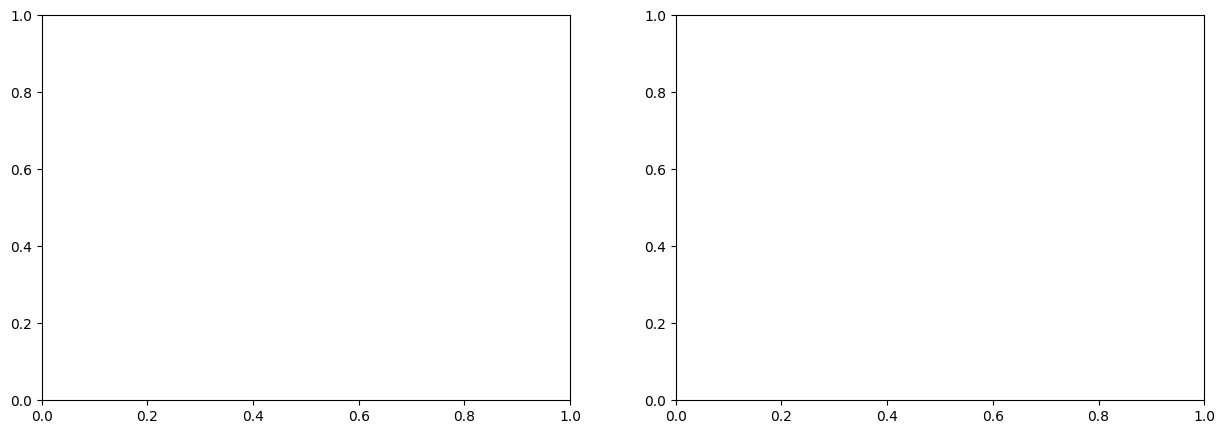

In [ ]:
plot_model_history(history)

26/26 [==============================] - 0s 7ms/step


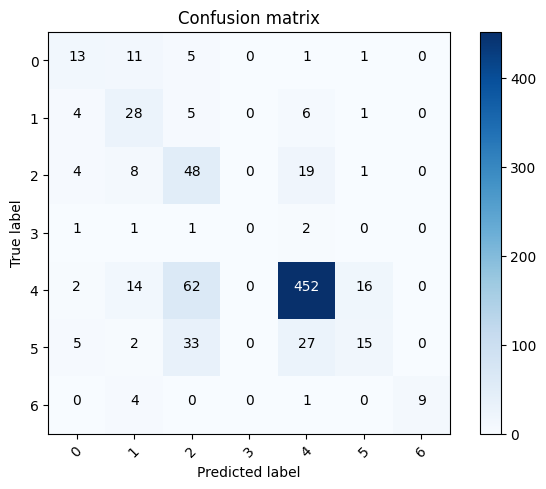

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

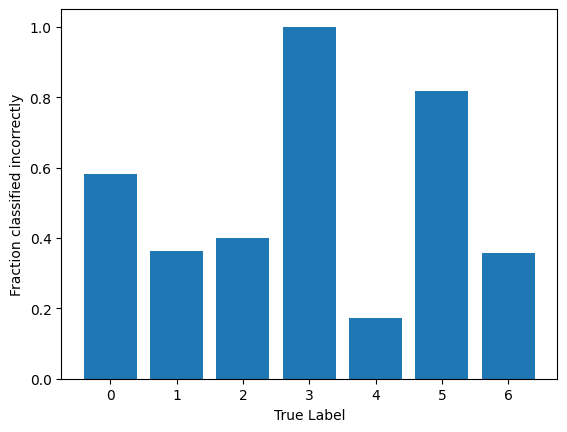

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')